In [1]:
import numpy as np
import matplotlib.pyplot as plt
from img_preprocessing import get_full_frame
from keras.optimizers import Adam, SGD

/home/aidan/anaconda3/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
val_den = np.load("./data/mall_processed/val-densities-small-blur.npy")
train_den = np.load("./data/mall_processed/train-densities-small-blur.npy")
val_imgs = np.load("./data/mall_processed/val-imgs.npy")
train_imgs = np.load("./data/mall_processed/train-imgs.npy")

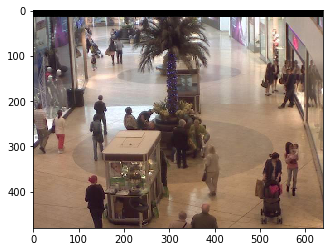

In [3]:
plt.imshow(train_imgs[0])

29000.000000000004

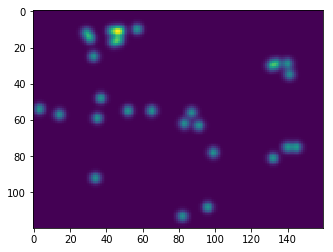

In [4]:
plt.imshow(train_den[0].reshape(train_den.shape[1], train_den.shape[2]))
np.sum(train_den[0])

In [27]:
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from loss import den_loss
from loss import den_loss_abs as abs_diff
import keras.losses
keras.losses.den_loss_sqr = den_loss

In [28]:
input_img = Input(shape=(480, 640, 3))
x = Conv2D(24, (5, 5), activation='relu' , padding="same")(input_img)
#x = Conv2D(24, (5, 5), activation='relu' , padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(48, (3, 3), activation='relu', padding="same")(x)
#x = Conv2D(48, (3, 3), activation='relu', padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(24, (3, 3), activation='relu', padding="same")(x)
x = Conv2D(12, (3, 3), activation='relu', padding="same")(x)

x = Conv2D(1, (1,1), activation='relu', padding="same")(x)

# x = UpSampling2D((2, 2))(x)
# x = UpSampling2D((2, 2))(x)

In [29]:
class AccuracyStopper(keras.callbacks.Callback):
    def __init__(self, look_back=5, target_slope=0.1):
        self.look_back = look_back
        self.target_slope = target_slope
    
    def on_train_begin(self, logs={}):
        self.acc = []
        self.epoch_count = 0

    def on_epoch_end(self, batch, logs={}):
        self.epoch_count += 1
        self.acc.append(logs.get('val_den_loss_abs'))
        if self.epoch_count >= self.look_back:
            acc_slope = 0
            acc_slope = (self.acc[self.epoch_count-1] - self.acc[self.epoch_count-self.look_back])/self.look_back
            print(" - abs_diff_slope: {}".format(acc_slope))
            if acc_slope < self.target_slope:
                print("abs_diff_slope is past the target_slope. Stopping training.")
                self.model.stop_training = True
        
acc_callback = AccuracyStopper(look_back=4, target_slope=0.1)
filepath="./small_column/checkpoints/small_column_weights.h5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=False, mode='max')
early_stopper = EarlyStopping(patience=0, monitor="val_loss")

In [30]:
callbacks_list = [early_stopper, checkpoint]
m = Model(input_img, x)
optimizer = Adam(lr=0.00000005)
#optimizer = SGD(lr=0.001)
m.compile(optimizer=optimizer, loss=den_loss, metrics=[abs_diff])
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 480, 640, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 480, 640, 24)      1824      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 240, 320, 24)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 240, 320, 48)      10416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 120, 160, 48)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 120, 160, 24)      10392     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 120, 160, 12)      2604      
__________

In [31]:
m.load_weights("./small_column/checkpoints/small_column_weights.h5")

In [32]:
history = m.fit(train_imgs, train_den, epochs=1000, batch_size=10, validation_data=(val_imgs, val_den), callbacks=callbacks_list)

Train on 750 samples, validate on 250 samples
Epoch 1/1000
740/750 [============================>.] - ETA: 0s - loss: 3751170.0135 - den_loss_abs: 247200.3480
Epoch 00001: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 20s 26ms/step - loss: 3755039.3633 - den_loss_abs: 247300.1694 - val_loss: 3824761.4800 - val_den_loss_abs: 264231.2581
Epoch 2/1000
740/750 [============================>.] - ETA: 0s - loss: 3759191.6318 - den_loss_abs: 247395.7420- ETA: 1s - loss: 3756020.2500 - den_loss_abs: 24735
Epoch 00002: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 16s 21ms/step - loss: 3755003.0033 - den_loss_abs: 247309.1329 - val_loss: 3824721.0100 - val_den_loss_abs: 264230.8994
Epoch 3/1000
740/750 [============================>.] - ETA: 0s - loss: 3757312.9932 - den_loss_abs: 247332.9212
Epoch 00003: saving model to ./small_column/checkpoints/small_column_weights.

Epoch 24/1000
740/750 [============================>.] - ETA: 0s - loss: 3752440.5676 - den_loss_abs: 247399.6803
Epoch 00024: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3754186.6467 - den_loss_abs: 247419.0004 - val_loss: 3823779.6600 - val_den_loss_abs: 264343.0963
Epoch 25/1000
740/750 [============================>.] - ETA: 0s - loss: 3747745.5372 - den_loss_abs: 247314.9037
Epoch 00025: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3754149.1033 - den_loss_abs: 247413.2096 - val_loss: 3823740.1800 - val_den_loss_abs: 264336.5900
Epoch 26/1000
740/750 [============================>.] - ETA: 0s - loss: 3745679.4899 - den_loss_abs: 247263.5148
Epoch 00026: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3754111.8033 - den_loss_abs

Epoch 47/1000
740/750 [============================>.] - ETA: 0s - loss: 3754369.8750 - den_loss_abs: 247586.0861
Epoch 00047: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3753320.5367 - den_loss_abs: 247518.6492 - val_loss: 3822789.9700 - val_den_loss_abs: 264429.0119
Epoch 48/1000
740/750 [============================>.] - ETA: 0s - loss: 3759990.5777 - den_loss_abs: 247658.1913
Epoch 00048: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3753282.6767 - den_loss_abs: 247507.1235 - val_loss: 3822745.8200 - val_den_loss_abs: 264434.4650
Epoch 49/1000
740/750 [============================>.] - ETA: 0s - loss: 3751264.2635 - den_loss_abs: 247454.5982
Epoch 00049: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3753244.0367 - den_loss_abs

Epoch 70/1000
740/750 [============================>.] - ETA: 0s - loss: 3747599.9662 - den_loss_abs: 247424.1035
Epoch 00070: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3752435.4533 - den_loss_abs: 247584.3329 - val_loss: 3821783.0300 - val_den_loss_abs: 264498.6144
Epoch 71/1000
740/750 [============================>.] - ETA: 0s - loss: 3758827.3547 - den_loss_abs: 247716.0997
Epoch 00071: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3752396.6167 - den_loss_abs: 247594.1117 - val_loss: 3821735.4000 - val_den_loss_abs: 264513.5300
Epoch 72/1000
740/750 [============================>.] - ETA: 0s - loss: 3746833.3514 - den_loss_abs: 247567.0938
Epoch 00072: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3752357.7667 - den_loss_abs

Epoch 93/1000
740/750 [============================>.] - ETA: 0s - loss: 3751388.5270 - den_loss_abs: 247669.9704
Epoch 00093: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3751541.9000 - den_loss_abs: 247668.0371 - val_loss: 3820765.5700 - val_den_loss_abs: 264570.7381
Epoch 94/1000
740/750 [============================>.] - ETA: 0s - loss: 3743311.2297 - den_loss_abs: 247472.5638
Epoch 00094: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3751503.4733 - den_loss_abs: 247676.9887 - val_loss: 3820720.8100 - val_den_loss_abs: 264575.0338
Epoch 95/1000
740/750 [============================>.] - ETA: 0s - loss: 3756989.9797 - den_loss_abs: 247833.8801
Epoch 00095: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3751464.0833 - den_loss_abs

Epoch 116/1000
740/750 [============================>.] - ETA: 0s - loss: 3754244.4831 - den_loss_abs: 247806.4443
Epoch 00116: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 16s 21ms/step - loss: 3750641.9600 - den_loss_abs: 247727.6577 - val_loss: 3819744.1300 - val_den_loss_abs: 264629.6644
Epoch 117/1000
740/750 [============================>.] - ETA: 0s - loss: 3746830.8581 - den_loss_abs: 247656.3543
Epoch 00117: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3750602.5267 - den_loss_abs: 247725.0400 - val_loss: 3819701.7500 - val_den_loss_abs: 264625.6700
Epoch 118/1000
740/750 [============================>.] - ETA: 0s - loss: 3749060.8412 - den_loss_abs: 247658.5171
Epoch 00118: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3750563.7567 - den_loss_

Epoch 139/1000
740/750 [============================>.] - ETA: 0s - loss: 3752805.3277 - den_loss_abs: 247888.2449
Epoch 00139: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3749731.0233 - den_loss_abs: 247784.5890 - val_loss: 3818711.7100 - val_den_loss_abs: 264682.3369
Epoch 140/1000
740/750 [============================>.] - ETA: 0s - loss: 3749425.8480 - den_loss_abs: 247714.7069
Epoch 00140: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3749690.5800 - den_loss_abs: 247784.6977 - val_loss: 3818667.4700 - val_den_loss_abs: 264681.5162
Epoch 141/1000
740/750 [============================>.] - ETA: 0s - loss: 3753112.8649 - den_loss_abs: 247849.5747
Epoch 00141: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3749650.5133 - den_loss_

Epoch 162/1000
740/750 [============================>.] - ETA: 0s - loss: 3753427.7939 - den_loss_abs: 247926.3535
Epoch 00162: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3748806.6867 - den_loss_abs: 247830.8087 - val_loss: 3817667.7500 - val_den_loss_abs: 264727.2369
Epoch 163/1000
740/750 [============================>.] - ETA: 0s - loss: 3747801.2736 - den_loss_abs: 247749.8602
Epoch 00163: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 16s 21ms/step - loss: 3748766.1533 - den_loss_abs: 247836.1308 - val_loss: 3817621.0600 - val_den_loss_abs: 264732.2838
Epoch 164/1000
740/750 [============================>.] - ETA: 0s - loss: 3743379.2095 - den_loss_abs: 247669.5076
Epoch 00164: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 17s 22ms/step - loss: 3748725.8167 - den_loss_

Epoch 185/1000
740/750 [============================>.] - ETA: 0s - loss: 3742117.0912 - den_loss_abs: 247824.7333
Epoch 00185: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3747872.0733 - den_loss_abs: 247874.0310 - val_loss: 3816614.0300 - val_den_loss_abs: 264765.1606
Epoch 186/1000
740/750 [============================>.] - ETA: 0s - loss: 3752257.2568 - den_loss_abs: 247916.3444
Epoch 00186: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3747831.1500 - den_loss_abs: 247871.3635 - val_loss: 3816567.9200 - val_den_loss_abs: 264767.4838
Epoch 187/1000
740/750 [============================>.] - ETA: 0s - loss: 3756339.8818 - den_loss_abs: 248083.5055
Epoch 00187: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3747790.4300 - den_loss_

Epoch 208/1000
740/750 [============================>.] - ETA: 0s - loss: 3747349.2399 - den_loss_abs: 247904.4329
Epoch 00208: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3746921.5100 - den_loss_abs: 247913.3394 - val_loss: 3815543.2300 - val_den_loss_abs: 264804.2675
Epoch 209/1000
740/750 [============================>.] - ETA: 0s - loss: 3753729.2770 - den_loss_abs: 248108.4364
Epoch 00209: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 16s 21ms/step - loss: 3746880.0533 - den_loss_abs: 247922.7483 - val_loss: 3815496.0300 - val_den_loss_abs: 264808.8306
Epoch 210/1000
740/750 [============================>.] - ETA: 0s - loss: 3740160.3818 - den_loss_abs: 247799.2513
Epoch 00210: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3746838.7500 - den_loss_

Epoch 231/1000
740/750 [============================>.] - ETA: 0s - loss: 3744628.7905 - den_loss_abs: 247863.9354
Epoch 00231: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3745960.7867 - den_loss_abs: 247967.4162 - val_loss: 3814460.4600 - val_den_loss_abs: 264847.2388
Epoch 232/1000
740/750 [============================>.] - ETA: 0s - loss: 3747721.8514 - den_loss_abs: 248050.9875
Epoch 00232: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3745919.4333 - den_loss_abs: 247957.2733 - val_loss: 3814416.0100 - val_den_loss_abs: 264840.5600
Epoch 233/1000
740/750 [============================>.] - ETA: 0s - loss: 3747714.5709 - den_loss_abs: 247993.6451
Epoch 00233: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3745877.1233 - den_loss_

Epoch 254/1000
740/750 [============================>.] - ETA: 0s - loss: 3745325.0878 - den_loss_abs: 247995.8575
Epoch 00254: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3744985.3600 - den_loss_abs: 247998.5181 - val_loss: 3813364.9200 - val_den_loss_abs: 264879.5119
Epoch 255/1000
740/750 [============================>.] - ETA: 0s - loss: 3744764.6385 - den_loss_abs: 248015.7857
Epoch 00255: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3744942.0900 - den_loss_abs: 248003.9398 - val_loss: 3813315.0100 - val_den_loss_abs: 264885.9881
Epoch 256/1000
740/750 [============================>.] - ETA: 0s - loss: 3752315.1622 - den_loss_abs: 248199.4772
Epoch 00256: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 14s 19ms/step - loss: 3744898.9100 - den_loss_

Epoch 277/1000
740/750 [============================>.] - ETA: 0s - loss: 3742674.5000 - den_loss_abs: 247983.1256
Epoch 00277: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3743995.7000 - den_loss_abs: 248030.4352 - val_loss: 3812256.5200 - val_den_loss_abs: 264905.2388
Epoch 278/1000
740/750 [============================>.] - ETA: 0s - loss: 3743660.9493 - den_loss_abs: 247986.0494
Epoch 00278: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3743952.1033 - den_loss_abs: 248022.5713 - val_loss: 3812207.5100 - val_den_loss_abs: 264907.7706
Epoch 279/1000
740/750 [============================>.] - ETA: 0s - loss: 3741861.1453 - den_loss_abs: 248073.7736
Epoch 00279: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3743908.9433 - den_loss_

Epoch 300/1000
740/750 [============================>.] - ETA: 0s - loss: 3746039.1318 - den_loss_abs: 248219.5367
Epoch 00300: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 16s 21ms/step - loss: 3742990.8667 - den_loss_abs: 248066.8200 - val_loss: 3811126.5800 - val_den_loss_abs: 264946.3850
Epoch 301/1000
740/750 [============================>.] - ETA: 0s - loss: 3748598.5541 - den_loss_abs: 248203.1368
Epoch 00301: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 18s 24ms/step - loss: 3742946.6867 - den_loss_abs: 248079.0492 - val_loss: 3811075.9000 - val_den_loss_abs: 264952.9944
Epoch 302/1000
740/750 [============================>.] - ETA: 0s - loss: 3740904.3041 - den_loss_abs: 247946.0572
Epoch 00302: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 21ms/step - loss: 3742902.7433 - den_loss_

Epoch 323/1000
740/750 [============================>.] - ETA: 0s - loss: 3743122.3514 - den_loss_abs: 248125.8617
Epoch 00323: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3741978.2067 - den_loss_abs: 248118.7969 - val_loss: 3809985.8500 - val_den_loss_abs: 264996.0906
Epoch 324/1000
740/750 [============================>.] - ETA: 0s - loss: 3746955.4223 - den_loss_abs: 248294.7061
Epoch 00324: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 16s 22ms/step - loss: 3741933.8633 - den_loss_abs: 248123.3681 - val_loss: 3809938.6900 - val_den_loss_abs: 264989.7687
Epoch 325/1000
740/750 [============================>.] - ETA: 0s - loss: 3747715.0912 - den_loss_abs: 248310.7612
Epoch 00325: saving model to ./small_column/checkpoints/small_column_weights.h5
750/750 [==============================] - 15s 20ms/step - loss: 3741889.6900 - den_loss_

KeyboardInterrupt: 

In [11]:
#m.save("small_column_v1-small-blur.h5")

In [21]:
print(history.history.keys())

dict_keys(['den_loss_abs', 'val_den_loss_abs', 'val_loss', 'loss'])


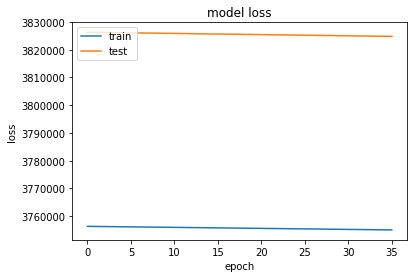

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

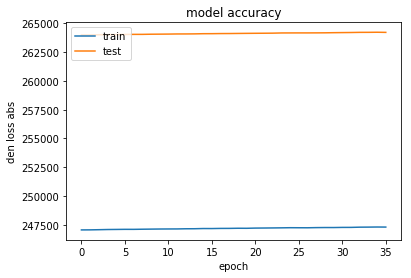

In [23]:
plt.plot(history.history['den_loss_abs'])
plt.plot(history.history['val_den_loss_abs'])
plt.title('model accuracy')
plt.ylabel('den loss abs')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

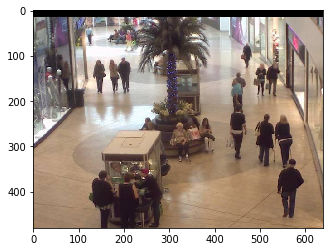

In [42]:
blur = True
sample_frame = 1999
frame = get_full_frame(sample_frame, blur=blur, scale_down=1)
img = frame["image"]
num_heads = len(frame["locations"])
ground_truth = frame["loc_img"].reshape((480, 640))

img_in = img.reshape((1, 480, 640, 3))
out = m.predict(img_in)
img_out = out.reshape((120, 160))
plt.imshow(img_in[0])

29.000000000000007
28.6027734375


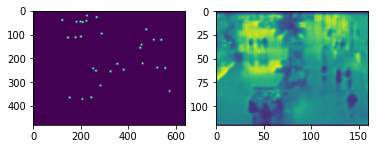

In [43]:
print(np.sum(ground_truth))
print(np.sum(img_out)/1000)
#plt.imshow(ground_truth)
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(ground_truth)
fig.add_subplot(1, 2, 2)
plt.imshow(img_out)

In [16]:
total_error = 0
total_sum = 0
average_error = 0
for i in range(2000):
    frame = get_full_frame(i, blur=blur, scale_down=1)
    num_heads = len(frame["locations"])
    img = frame["image"]
    img_in = img.reshape((1, 480, 640, 3))
    out = m.predict(img_in)
    diff = (np.sum(out)/1000) - num_heads
    total_error += abs(diff)
    total_sum += diff
    average_error = total_error/i
    average_sum = total_sum/i
    print("Average Error: {}, Average Sum: {}".format(average_error, average_sum))

Average Error: inf, Average Sum: inf


/home/aidan/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/home/aidan/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


Average Error: 702.5201416015625, Average Sum: 702.5201416015625
Average Error: 524.6304779052734, Average Sum: 524.6304779052734
Average Error: 467.01475016276044, Average Sum: 467.01475016276044
Average Error: 439.2016143798828, Average Sum: 439.2016143798828
Average Error: 422.3900390625, Average Sum: 422.3900390625
Average Error: 411.0695088704427, Average Sum: 411.0695088704427
Average Error: 403.1538521902902, Average Sum: 403.1538521902902
Average Error: 396.4541816711426, Average Sum: 396.4541816711426
Average Error: 390.8003573947483, Average Sum: 390.8003573947483
Average Error: 385.5929321289062, Average Sum: 385.5929321289062
Average Error: 380.93480890447444, Average Sum: 380.93480890447444
Average Error: 376.9395039876302, Average Sum: 376.9395039876302
Average Error: 373.5350576547476, Average Sum: 373.5350576547476
Average Error: 371.1072910853795, Average Sum: 371.1072910853795
Average Error: 369.0149393717448, Average Sum: 369.0149393717448
Average Error: 367.18996238

Average Error: 355.58875112458475, Average Sum: 355.58875112458475
Average Error: 355.65365719795227, Average Sum: 355.65365719795227
Average Error: 355.72157394054324, Average Sum: 355.72157394054324
Average Error: 355.76788470928483, Average Sum: 355.76788470928483
Average Error: 355.8214134623986, Average Sum: 355.8214134623986
Average Error: 355.8652850064364, Average Sum: 355.8652850064364
Average Error: 355.8805076197574, Average Sum: 355.8805076197574
Average Error: 355.9143881726621, Average Sum: 355.9143881726621
Average Error: 355.9996704101562, Average Sum: 355.9996704101562
Average Error: 356.0864913042854, Average Sum: 356.0864913042854
Average Error: 356.1852766719178, Average Sum: 356.1852766719178
Average Error: 356.25114264004475, Average Sum: 356.25114264004475
Average Error: 356.335019777147, Average Sum: 356.335019777147
Average Error: 356.4394570486886, Average Sum: 356.4394570486886
Average Error: 356.5480210324551, Average Sum: 356.5480210324551
Average Error: 35

Average Error: 362.43268500434027, Average Sum: 362.43268500434027
Average Error: 362.4906444926507, Average Sum: 362.4906444926507
Average Error: 362.54977116622325, Average Sum: 362.54977116622325
Average Error: 362.59784198835786, Average Sum: 362.59784198835786
Average Error: 362.6658844947815, Average Sum: 362.6658844947815
Average Error: 362.74765370884757, Average Sum: 362.74765370884757
Average Error: 362.8078939748365, Average Sum: 362.8078939748365
Average Error: 362.85231353877595, Average Sum: 362.85231353877595
Average Error: 362.90529374342697, Average Sum: 362.90529374342697
Average Error: 362.93201981467763, Average Sum: 362.93201981467763
Average Error: 362.96164464586565, Average Sum: 362.96164464586565
Average Error: 362.9841381696694, Average Sum: 362.9841381696694
Average Error: 362.9637452327844, Average Sum: 362.9637452327844
Average Error: 362.9364720758402, Average Sum: 362.9364720758402
Average Error: 362.88411706910097, Average Sum: 362.88411706910097
Average

Average Error: 361.7500693507926, Average Sum: 361.7500693507926
Average Error: 361.66306612925666, Average Sum: 361.66306612925666
Average Error: 361.5607199417917, Average Sum: 361.5607199417917
Average Error: 361.4746368488302, Average Sum: 361.4746368488302
Average Error: 361.4134030167345, Average Sum: 361.4134030167345
Average Error: 361.3577096804626, Average Sum: 361.3577096804626
Average Error: 361.3109414577484, Average Sum: 361.3109414577484
Average Error: 361.2700923771053, Average Sum: 361.2700923771053
Average Error: 361.21169134742854, Average Sum: 361.21169134742854
Average Error: 361.1591010672794, Average Sum: 361.1591010672794
Average Error: 361.1278722704071, Average Sum: 361.1278722704071
Average Error: 361.1126239845256, Average Sum: 361.1126239845256
Average Error: 361.0846189058744, Average Sum: 361.0846189058744
Average Error: 361.0473084900995, Average Sum: 361.0473084900995
Average Error: 360.988903668462, Average Sum: 360.988903668462
Average Error: 360.9153

Average Error: 359.0421901279026, Average Sum: 359.0421901279026
Average Error: 359.05519179542466, Average Sum: 359.05519179542466
Average Error: 359.0669308990358, Average Sum: 359.0669308990358
Average Error: 359.0836588541667, Average Sum: 359.0836588541667
Average Error: 359.0897548405204, Average Sum: 359.0897548405204
Average Error: 359.10651660012354, Average Sum: 359.10651660012354
Average Error: 359.1203192018995, Average Sum: 359.1203192018995
Average Error: 359.1345242315542, Average Sum: 359.1345242315542
Average Error: 359.1368567943573, Average Sum: 359.1368567943573
Average Error: 359.12010404055115, Average Sum: 359.12010404055115
Average Error: 359.08644252435704, Average Sum: 359.08644252435704
Average Error: 359.0651768360323, Average Sum: 359.0651768360323
Average Error: 359.0386243125265, Average Sum: 359.0386243125265
Average Error: 359.0139279393209, Average Sum: 359.0139279393209
Average Error: 358.9934325936218, Average Sum: 358.9934325936218
Average Error: 35

Average Error: 358.83184334128765, Average Sum: 358.83184334128765
Average Error: 358.83533339727495, Average Sum: 358.83533339727495
Average Error: 358.8327533220149, Average Sum: 358.8327533220149
Average Error: 358.8180592210987, Average Sum: 358.8180592210987
Average Error: 358.80894790818155, Average Sum: 358.80894790818155
Average Error: 358.80793911425474, Average Sum: 358.80793911425474
Average Error: 358.81251355268824, Average Sum: 358.81251355268824
Average Error: 358.8220901969094, Average Sum: 358.8220901969094
Average Error: 358.81887151457636, Average Sum: 358.81887151457636
Average Error: 358.8070330485281, Average Sum: 358.8070330485281
Average Error: 358.797034417333, Average Sum: 358.797034417333
Average Error: 358.7834455013275, Average Sum: 358.7834455013275
Average Error: 358.7616935646664, Average Sum: 358.7616935646664
Average Error: 358.7319856922946, Average Sum: 358.7319856922946
Average Error: 358.6947387410545, Average Sum: 358.6947387410545
Average Error: 

Average Error: 357.1867840697434, Average Sum: 357.1867840697434
Average Error: 357.1504112122551, Average Sum: 357.1504112122551
Average Error: 357.1228003961722, Average Sum: 357.1228003961722
Average Error: 357.09904596736374, Average Sum: 357.09904596736374
Average Error: 357.0675817597682, Average Sum: 357.0675817597682
Average Error: 357.044936732242, Average Sum: 357.044936732242
Average Error: 357.0288140075122, Average Sum: 357.0288140075122
Average Error: 357.01984511648266, Average Sum: 357.01984511648266
Average Error: 357.01507152392384, Average Sum: 357.01507152392384
Average Error: 357.01268772304996, Average Sum: 357.01268772304996
Average Error: 357.0189815346712, Average Sum: 357.0189815346712
Average Error: 357.0227110939922, Average Sum: 357.0227110939922
Average Error: 357.0343401136734, Average Sum: 357.0343401136734
Average Error: 357.0531009038289, Average Sum: 357.0531009038289
Average Error: 357.07269092654064, Average Sum: 357.07269092654064
Average Error: 35

Average Error: 357.0409352955293, Average Sum: 357.0409352955293
Average Error: 357.03099938909486, Average Sum: 357.03099938909486
Average Error: 357.01668129528906, Average Sum: 357.01668129528906
Average Error: 356.998850826764, Average Sum: 356.998850826764
Average Error: 356.97990295065324, Average Sum: 356.97990295065324
Average Error: 356.95928903411794, Average Sum: 356.95928903411794
Average Error: 356.93780259537726, Average Sum: 356.93780259537726
Average Error: 356.9218595006444, Average Sum: 356.9218595006444
Average Error: 356.9030164755101, Average Sum: 356.9030164755101
Average Error: 356.89404835218795, Average Sum: 356.89404835218795
Average Error: 356.88736393475773, Average Sum: 356.88736393475773
Average Error: 356.8738722865357, Average Sum: 356.8738722865357
Average Error: 356.85009324777565, Average Sum: 356.85009324777565
Average Error: 356.831600283083, Average Sum: 356.831600283083
Average Error: 356.81946769160265, Average Sum: 356.81946769160265
Average Err

Average Error: 355.7260476711845, Average Sum: 355.7260476711845
Average Error: 355.7191634405227, Average Sum: 355.7191634405227
Average Error: 355.7148128392321, Average Sum: 355.7148128392321
Average Error: 355.70977027817526, Average Sum: 355.70977027817526
Average Error: 355.7044380104978, Average Sum: 355.7044380104978
Average Error: 355.6991733355013, Average Sum: 355.6991733355013
Average Error: 355.6957699021606, Average Sum: 355.6957699021606
Average Error: 355.69200089133, Average Sum: 355.69200089133
Average Error: 355.6994268107297, Average Sum: 355.6994268107297
Average Error: 355.7002318975494, Average Sum: 355.7002318975494
Average Error: 355.6996121476885, Average Sum: 355.6996121476885
Average Error: 355.69858705411957, Average Sum: 355.69858705411957
Average Error: 355.7009058719294, Average Sum: 355.7009058719294
Average Error: 355.70266080370135, Average Sum: 355.70266080370135
Average Error: 355.70684303336, Average Sum: 355.70684303336
Average Error: 355.71502449

Average Error: 356.1540317888302, Average Sum: 356.1540317888302
Average Error: 356.14187506554833, Average Sum: 356.14187506554833
Average Error: 356.1269252377848, Average Sum: 356.1269252377848
Average Error: 356.11146561500266, Average Sum: 356.11146561500266
Average Error: 356.09544786515204, Average Sum: 356.09544786515204
Average Error: 356.0756141796447, Average Sum: 356.0756141796447
Average Error: 356.0506714295129, Average Sum: 356.0506714295129
Average Error: 356.0205621936484, Average Sum: 356.0205621936484
Average Error: 355.992006396997, Average Sum: 355.992006396997
Average Error: 355.9647344042371, Average Sum: 355.9647344042371
Average Error: 355.9394901725403, Average Sum: 355.9394901725403
Average Error: 355.9154195202999, Average Sum: 355.9154195202999
Average Error: 355.8918480977039, Average Sum: 355.8918480977039
Average Error: 355.86871460173603, Average Sum: 355.86871460173603
Average Error: 355.8423061653051, Average Sum: 355.8423061653051
Average Error: 355.

Average Error: 355.8621547375285, Average Sum: 355.8621547375285
Average Error: 355.85759371169587, Average Sum: 355.85759371169587
Average Error: 355.8496272796123, Average Sum: 355.8496272796123
Average Error: 355.8351882258548, Average Sum: 355.8351882258548
Average Error: 355.8213108711092, Average Sum: 355.8213108711092
Average Error: 355.80245359399686, Average Sum: 355.80245359399686
Average Error: 355.7810104358074, Average Sum: 355.7810104358074
Average Error: 355.7639054018616, Average Sum: 355.7639054018616
Average Error: 355.74998985152246, Average Sum: 355.74998985152246
Average Error: 355.73674681656, Average Sum: 355.73674681656
Average Error: 355.72077844651267, Average Sum: 355.72077844651267
Average Error: 355.701477458642, Average Sum: 355.701477458642
Average Error: 355.6851546773738, Average Sum: 355.6851546773738
Average Error: 355.66696555049305, Average Sum: 355.66696555049305
Average Error: 355.6509217744715, Average Sum: 355.6509217744715
Average Error: 355.63

Average Error: 355.9477660956792, Average Sum: 355.9477660956792
Average Error: 355.93278200001123, Average Sum: 355.93278200001123
Average Error: 355.91814706581283, Average Sum: 355.91814706581283
Average Error: 355.9019216413978, Average Sum: 355.9019216413978
Average Error: 355.89054696187964, Average Sum: 355.89054696187964
Average Error: 355.8765159694628, Average Sum: 355.8765159694628
Average Error: 355.86444282394814, Average Sum: 355.86444282394814
Average Error: 355.84840587906035, Average Sum: 355.84840587906035
Average Error: 355.8338448254438, Average Sum: 355.8338448254438
Average Error: 355.82318078071137, Average Sum: 355.82318078071137
Average Error: 355.81656451761165, Average Sum: 355.81656451761165
Average Error: 355.80962193916116, Average Sum: 355.80962193916116
Average Error: 355.79894487273276, Average Sum: 355.79894487273276
Average Error: 355.7919069998605, Average Sum: 355.7919069998605
Average Error: 355.7875046222913, Average Sum: 355.7875046222913
Average

Average Error: 354.96332769400226, Average Sum: 354.96332769400226
Average Error: 354.96448308221574, Average Sum: 354.96448308221574
Average Error: 354.9667404527318, Average Sum: 354.9667404527318
Average Error: 354.96825076785126, Average Sum: 354.96825076785126
Average Error: 354.9703361093801, Average Sum: 354.9703361093801
Average Error: 354.97423200644994, Average Sum: 354.97423200644994
Average Error: 354.97971738271605, Average Sum: 354.97971738271605
Average Error: 354.9847019998651, Average Sum: 354.9847019998651
Average Error: 354.9898227187538, Average Sum: 354.9898227187538
Average Error: 354.9910295564148, Average Sum: 354.9910295564148
Average Error: 354.99522356821063, Average Sum: 354.99522356821063
Average Error: 355.00046927784996, Average Sum: 355.00046927784996
Average Error: 355.0060425405033, Average Sum: 355.0060425405033
Average Error: 355.01690613832886, Average Sum: 355.01690613832886
Average Error: 355.0271651811981, Average Sum: 355.0271651811981
Average E

Average Error: 354.7802250155308, Average Sum: 354.7802250155308
Average Error: 354.76544932376476, Average Sum: 354.76544932376476
Average Error: 354.75687977860616, Average Sum: 354.75687977860616
Average Error: 354.74837072210875, Average Sum: 354.74837072210875
Average Error: 354.73466794644725, Average Sum: 354.73466794644725
Average Error: 354.72263308784545, Average Sum: 354.72263308784545
Average Error: 354.7096276016421, Average Sum: 354.7096276016421
Average Error: 354.6953059326914, Average Sum: 354.6953059326914
Average Error: 354.6814557767291, Average Sum: 354.6814557767291
Average Error: 354.66683304027566, Average Sum: 354.66683304027566
Average Error: 354.6551450340493, Average Sum: 354.6551450340493
Average Error: 354.63799018003925, Average Sum: 354.63799018003925
Average Error: 354.6182491233132, Average Sum: 354.6182491233132
Average Error: 354.5996460293655, Average Sum: 354.5996460293655
Average Error: 354.5859789721325, Average Sum: 354.5859789721325
Average Err

Average Error: 354.57760519775945, Average Sum: 354.57760519775945
Average Error: 354.5671028115594, Average Sum: 354.5671028115594
Average Error: 354.5616544246134, Average Sum: 354.5616544246134
Average Error: 354.5493330208002, Average Sum: 354.5493330208002
Average Error: 354.5361002581152, Average Sum: 354.5361002581152
Average Error: 354.5231568555902, Average Sum: 354.5231568555902
Average Error: 354.51048732261876, Average Sum: 354.51048732261876
Average Error: 354.49921907051214, Average Sum: 354.49921907051214
Average Error: 354.48448554872124, Average Sum: 354.48448554872124
Average Error: 354.4735897126604, Average Sum: 354.4735897126604
Average Error: 354.46267225400976, Average Sum: 354.46267225400976
Average Error: 354.45277857820753, Average Sum: 354.45277857820753
Average Error: 354.4443239435419, Average Sum: 354.4443239435419
Average Error: 354.4352881539452, Average Sum: 354.4352881539452
Average Error: 354.42655067744215, Average Sum: 354.42655067744215
Average Err

Average Error: 354.000156163037, Average Sum: 354.000156163037
Average Error: 354.0078280002256, Average Sum: 354.0078280002256
Average Error: 354.0185750540018, Average Sum: 354.0185750540018
Average Error: 354.0281660041769, Average Sum: 354.0281660041769
Average Error: 354.0340990465274, Average Sum: 354.0340990465274
Average Error: 354.0376388228567, Average Sum: 354.0376388228567
Average Error: 354.04032006180955, Average Sum: 354.04032006180955
Average Error: 354.0449482850597, Average Sum: 354.0449482850597
Average Error: 354.0499659190977, Average Sum: 354.0499659190977
Average Error: 354.05678439741376, Average Sum: 354.05678439741376
Average Error: 354.06100857952447, Average Sum: 354.06100857952447
Average Error: 354.06254388703127, Average Sum: 354.06254388703127
Average Error: 354.0647149648601, Average Sum: 354.0647149648601
Average Error: 354.07000441321287, Average Sum: 354.07000441321287
Average Error: 354.0735793196137, Average Sum: 354.0735793196137
Average Error: 35